In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
train_data_path = './data/train'

In [4]:
test_data_path = './data/test'

In [2]:
weights = models.ResNet18_Weights.DEFAULT

In [17]:
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std)
])

In [8]:
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std)
])

In [18]:
train_dataset = torchvision.datasets.ImageFolder(root = train_data_path, transform = train_transforms)

In [13]:
test_dataset = torchvision.datasets.ImageFolder(root = test_data_path, transform = test_transforms)

In [22]:
def show_new_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle = True)
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize=(11, 11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print('labels', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


labels tensor([4, 2, 8, 6, 1, 6])


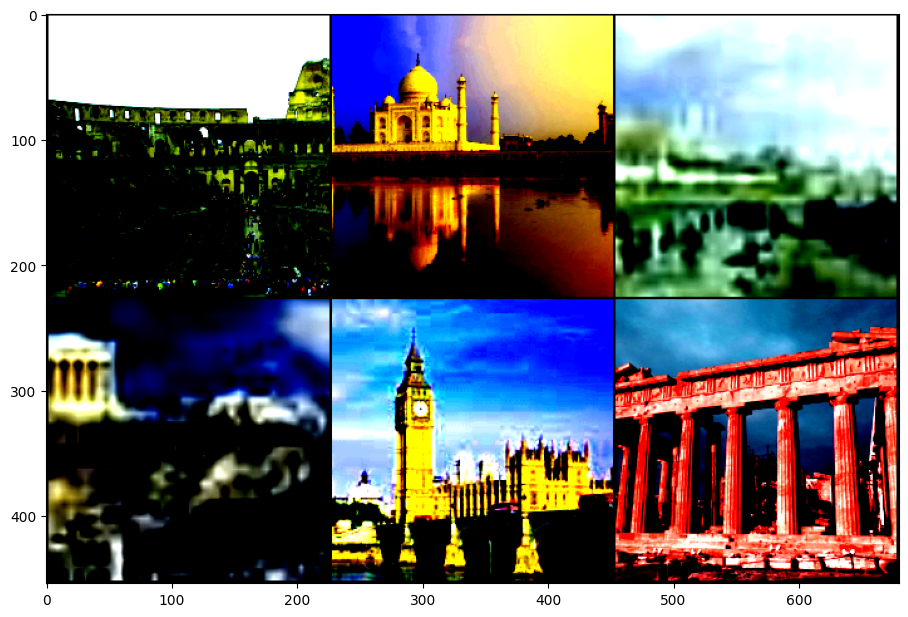

In [23]:
show_new_images(train_dataset)

In [24]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=32, shuffle=True, num_workers=4)

In [25]:
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [26]:
class_names = ["Eiffel Tower_1", "Taj-Mahal_2", "machu picchu_3", "Coliseum_4", 
               "Great Wall of China_5", "Acropolis of Athens_6", "Louvre_7", 
               "Moscow Kremlin_8", "Milan Cathedral_9", "big ben_10"]

In [27]:
len(class_names)

10

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### ResNet18

In [29]:
model = models.resnet18(weights=weights)

In [30]:
#Заморозка весов
for param in model.parameters():
    param.requires_grad = False

In [31]:
num_ftrs = model.fc.in_features

In [32]:
model.fc = nn.Linear(num_ftrs, len(class_names))

In [33]:
model = model.to(device)

In [40]:
loss_function = nn.CrossEntropyLoss()

In [35]:
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

### Training Loop

In [42]:
import datetime

def train_model(n_epochs, optimizer, model, loss_function, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print("{} Epoch{}, Training Loss {}".format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

            

In [43]:
train_model(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_function = loss_function,
    train_loader = train_loader)

2025-06-17 20:09:25.523194 Epoch1, Training Loss 1.4852684686581294
2025-06-17 20:12:45.904111 Epoch10, Training Loss 0.554166084776322
2025-06-17 20:15:58.606815 Epoch20, Training Loss 0.37494287826120853
2025-06-17 20:19:11.517140 Epoch30, Training Loss 0.29940466086069745
2025-06-17 20:22:25.589401 Epoch40, Training Loss 0.26520626867810887
2025-06-17 20:24:57.332508 Epoch50, Training Loss 0.235705372877419
2025-06-17 20:27:23.689239 Epoch60, Training Loss 0.21576600521802902
2025-06-17 20:29:56.423608 Epoch70, Training Loss 0.1939952289685607
2025-06-17 20:32:31.185508 Epoch80, Training Loss 0.18966303983082375
2025-06-17 20:35:04.365040 Epoch90, Training Loss 0.17166800082971653
2025-06-17 20:37:46.060659 Epoch100, Training Loss 0.1776163000613451


In [44]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=32, shuffle=False, num_workers=4)

In [51]:
def evaluate_model(model, train_loader, test_loader):
    model.eval() #модель в режиме оценки
    for name, loader in [("train", train_loader), ("val", test_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs= model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))

In [52]:
evaluate_model(model, train_loader, test_loader)

Accuracy train: 0.98
Accuracy val: 0.90


In [53]:
torch.save(model.state_dict(), train_data_path + "landmarks.pt")

In [54]:
loaded_model = model
loaded_model.load_state_dict(torch.load(train_data_path + "landmarks.pt"))

<All keys matched successfully>

### Пример с новыми фотографиями

In [55]:
from PIL import Image

In [57]:
pic_1_path = 'example_1.jpg'
pic_2_path = 'example_2.jpeg'

In [58]:
image_1 = Image.open(pic_1_path)
image_2 = Image.open(pic_2_path)

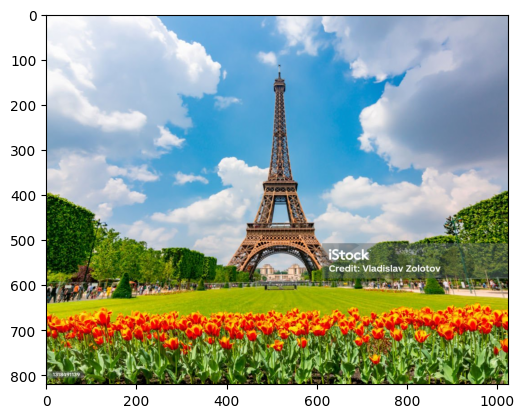

In [59]:
pic_1_plot = plt.imshow(image_1)

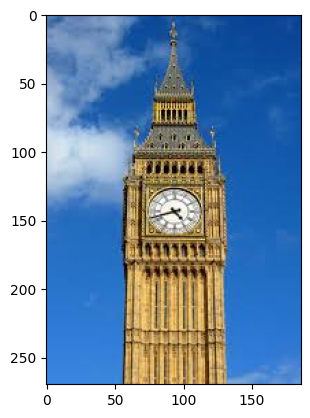

In [60]:
pic_2_plot = plt.imshow(image_2)

In [63]:
new_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std)
])

In [64]:
transform_pic_1 = new_transform(image_1)
transform_pic_2 = new_transform(image_2)

In [65]:
def show_transform_images(tensor, title=None):
    image = tensor.numpy().transpose((1, 2, 0))
    mean = weights.transforms().mean
    std = weights.transforms().std
    image = std * image + mean
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(.001)

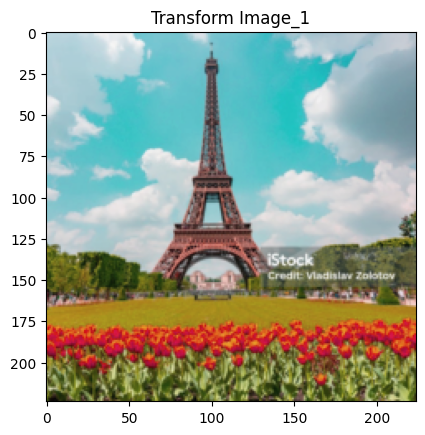

In [66]:
show_transform_images(transform_pic_1, title="Transform Image_1")

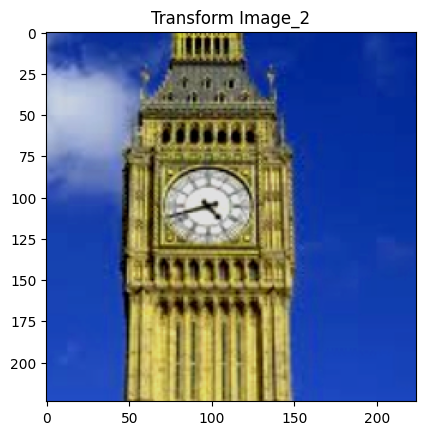

In [67]:
show_transform_images(transform_pic_2, title="Transform Image_2")

In [68]:
def load_image(image_path):
    image = Image.open(image_path)
    image = new_transform(image)
    image = image.unsqueeze(0)
    return image

In [69]:
image_path = ["example_1.jpg", "example_2.jpeg"]

In [70]:
images = [load_image(img) for img in image_path]

In [71]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [73]:
with torch.no_grad():
    for image in images:
        image = image.to(device=device)
        output = model(image)
        _, predicted = torch.max(output, 1)
        print(f"Prediction: {class_names[predicted.item()]}")

Prediction: Eiffel Tower_1
Prediction: Taj-Mahal_2
